# Analysis of the effect of vessel depth

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from pymcx import read_output_file, load_mcx_settings
from spectra import blood_mu_a, melanosome_mu_a, water_mu_a

matplotlib.rcParams['figure.figsize'] = (5,4)
matplotlib.rcParams.update({'font.size': 18})

Load the list of parameters run and the files containing the output and settings files. The constant variables are removed for the summary tables.

In [32]:
parameters = pd.read_csv("params.csv", index_col=0)
# Simulations were run for a couple of different melanin concentrations.
parameters = parameters[parameters["Melanin"]==0.01]
parameters.loc[:, parameters.nunique()>1]

,VesselDepth,Wavelength,OutputFile,VolumeFile,SettingsFile
21,0.001,7.000000e-07,result_0_1_00.mc2,volume_0.bin,settings_0_1_00.json
22,0.001,7.100000e-07,result_0_1_01.mc2,volume_0.bin,settings_0_1_01.json
23,0.001,7.200000e-07,result_0_1_02.mc2,volume_0.bin,settings_0_1_02.json
24,0.001,7.300000e-07,result_0_1_03.mc2,volume_0.bin,settings_0_1_03.json
25,0.001,7.400000e-07,result_0_1_04.mc2,volume_0.bin,settings_0_1_04.json
...,...,...,...,...,...
373,0.005,8.600000e-07,result_8_1_16.mc2,volume_8.bin,settings_8_1_16.json
374,0.005,8.700000e-07,result_8_1_17.mc2,volume_8.bin,settings_8_1_17.json
375,0.005,8.800000e-07,result_8_1_18.mc2,volume_8.bin,settings_8_1_18.json
376,0.005,8.900000e-07,result_8_1_19.mc2,volume_8.bin,settings_8_1_19.json


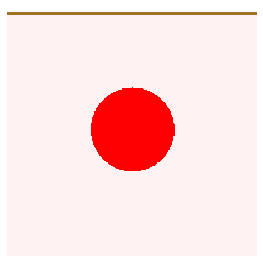

In [33]:
# View the phantom
settings = parameters["SettingsFile"].iloc[0]

# Load the phantom settings.
mcx_settings = load_mcx_settings(settings)
dimension = tuple(mcx_settings["Domain"]["Dim"])

volume_numbered = []

for volfile in parameters["VolumeFile"].unique():
    volume = np.fromfile(volfile, dtype="uint8").reshape(dimension + (-1,), order="F")
    # Visualise the computational phantom.
    volume_numbered.append(volume[:, 100, :, 0])

cmap = matplotlib.colors.ListedColormap([(1,1,1), (163/255, 113/255, 38/255), (1, 0.95, 0.95), (1,0,0)])
plt.imshow(volume_numbered[5].T, cmap=cmap)
plt.axis("off")
plt.tight_layout()
plt.savefig("../FiguresOutput/phantom_layout.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()
    
# Labels for each region.
regions = ["Outside", "Coupling Layer", "Epidermis", "Background", "Vessel"]

Load the simulated results, convert to a two-dimensional slice.

In [34]:
ms_results = []
# Define in the independent variable which is varied in the experiment.
variable = "VesselDepth"
labels = parameters[variable].unique()
for dep_variable in labels:
    selection = parameters[parameters[variable] == dep_variable]
    test = np.zeros((200, 200, 21), order="F")
    for i, (result_file, settings_file) in enumerate(zip(selection["OutputFile"], selection["SettingsFile"])):
        settings = load_mcx_settings(settings_file)
        result = read_output_file(result_file, settings)
        test[:, :, i] = np.sum(result[:, 90:110, :, 0], axis=1)
        # test[:, :, i] = result[:, 100, :, 0]
    ms_results.append(test)

## Total energy absorption over the blood vessel averaged over wavelength

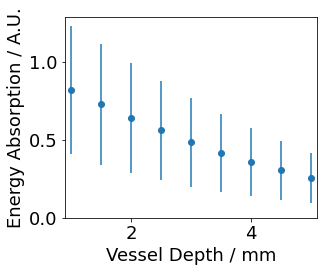

In [35]:
labels_um = [l*1e3 for l in labels]
#plt.boxplot([np.mean(s[volume_numbered[i] == 4], axis=1) for i, s in enumerate(ms_results)], showfliers=False, labels=labels_um)
#plt.xlabel(r"Vessel Depth / $\mu$m")
#plt.ylabel("Energy Absorption / A.U.")
#plt.show()
absorption = [np.mean(s[volume_numbered[i] == 4], axis=1) for i, s in enumerate(ms_results)]
abs_means = np.array(list(map(np.mean, absorption)))/1000
abs_stds = np.array(list(map(np.std, absorption)))/1000
plt.errorbar(labels_um, abs_means, yerr=abs_stds, fmt="o")
plt.xlabel(r"Vessel Depth / mm")
plt.ylabel("Energy Absorption / A.U.")
plt.ylim([0,None])
plt.xlim(0.9,5.1)
plt.tight_layout()
plt.savefig("../FiguresOutput/depth_abs.png", bbox_inches = 'tight',pad_inches = 0)
plt.show()

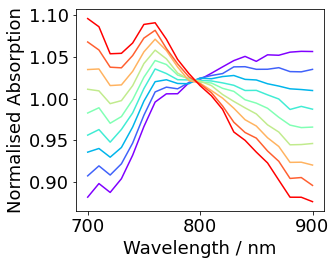

In [36]:
# Calculate the mean absorption spectra over the entire blood vessel over the independent variable.
mean_specs = [np.mean(result[volume_numbered[i] == 4], axis=0) for i, result in enumerate(ms_results)]

evenly_spaced_interval = np.linspace(0, 1, len(mean_specs))
line_colors = [matplotlib.cm.rainbow(x) for x in evenly_spaced_interval]

wavelengths = parameters["Wavelength"].unique()
for spec, label, color in zip(mean_specs, labels, line_colors):
    plt.plot(1e9*wavelengths, spec/np.mean(spec), label=label, color=color)
plt.xlabel("Wavelength / nm")
plt.ylabel("Normalised Absorption")
plt.tight_layout()
plt.savefig("../FiguresOutput/depth_spec.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

# Spectral Unmixing

In [37]:
# Load the basis spectra
hb = blood_mu_a(wavelengths, 0, water = False)
hbo2 = blood_mu_a(wavelengths, 1, water = False)
water = water_mu_a(wavelengths)
melanin = melanosome_mu_a(wavelengths)
test = np.ones_like(wavelengths)

# Calculate the forward and (pseudo)-inverse matrices
spectra_matrix = np.array([hb, hbo2, water, melanin]).T
inv_matrix = np.linalg.pinv(spectra_matrix)

# Apply the unmixing matrix
print(ms_results[0].shape)
unmixed = [np.dot(result, inv_matrix.T) for result in ms_results]
so2 = [M[:, :, 1]/(M[:, :, 1] + M[:, :, 0]) for M in unmixed]
THb = [M[:, :, 1]+M[:, :, 0] for M in unmixed]

(200, 200, 21)


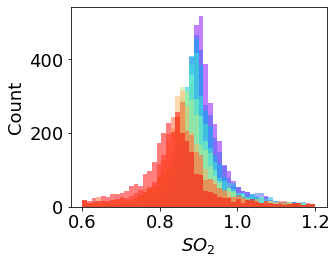

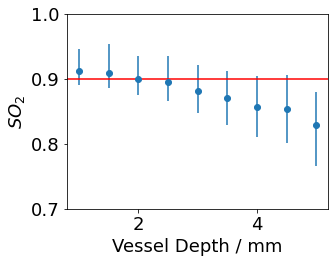

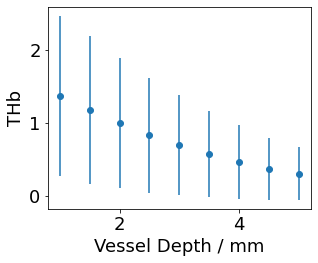

In [38]:
evenly_spaced_interval = np.linspace(0, 1, len(labels))
line_colors = [matplotlib.cm.rainbow(x) for x in evenly_spaced_interval]

for i, (s, label, color) in enumerate(zip(so2, labels, line_colors)):
    plt.hist(s[volume_numbered[i] == 4], bins=50, range=(0.6,1.2), label=label, alpha=0.5, color=color)
plt.xlabel("$SO_2$")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../FiguresOutput/depth_SO2_hist.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

so2s = [s[volume_numbered[i] == 4] for i, s in enumerate(so2)]
means = np.array(list(map(np.median, so2s)))
stds = np.abs(means[:, None] - np.array(list(map(lambda x:np.percentile(x,[25,75]), so2s))))

#plt.boxplot([s[volume_numbered[i] == 4] for i, s in enumerate(so2)], showfliers=False, labels=labels_um)
plt.errorbar(labels_um, means, yerr=stds.T, fmt="o")
plt.xlabel(r"Vessel Depth / mm")
plt.ylabel("$SO_2$")
plt.ylim([0.7,1])
plt.axhline(0.9, c="r")
plt.tight_layout()
plt.savefig("../FiguresOutput/depth_SO2.png", bbox_inches = 'tight', pad_inches = 0)

plt.show()


so2s = [s[volume_numbered[i] == 4] for i, s in enumerate(THb)]
means = np.array(list(map(np.mean, so2s)))
stds = np.array(list(map(np.std, so2s)))

#plt.boxplot([s[volume_numbered[i] == 4] for i, s in enumerate(so2)], showfliers=False, labels=labels_um)
plt.errorbar(labels_um, means, yerr=stds.T, fmt="o")
plt.xlabel(r"Vessel Depth / mm")
plt.ylabel("THb")
plt.tight_layout()
plt.savefig("../FiguresOutput/depth_THb.png", bbox_inches = 'tight', pad_inches = 0)

plt.show()

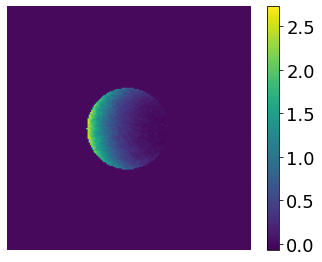

In [39]:
# Check that we're selecting the correct ROI
n=5
plt.imshow(THb[n] * (volume_numbered[n] == 4))
plt.colorbar()
plt.axis("off")
plt.tight_layout()
plt.show()

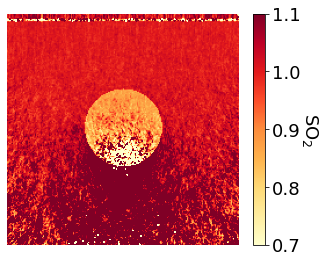

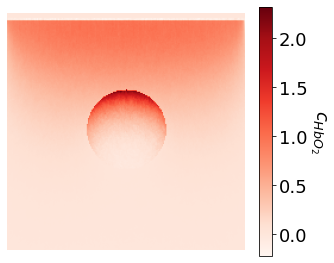

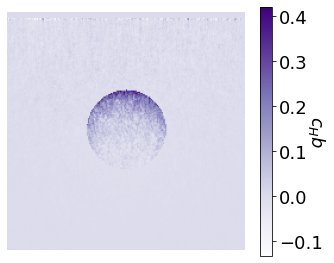

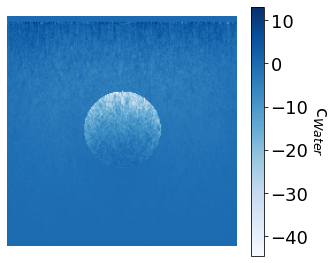

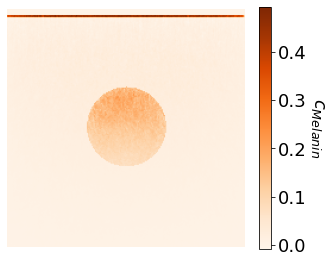

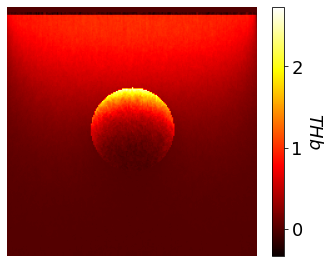

In [59]:
# SO2
plt.imshow(so2[n].T, cmap="YlOrRd", clim=(0.7,1.1))
cb = plt.colorbar()
cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel('SO$_2$', rotation=270)
plt.axis("off")
plt.tight_layout()
plt.savefig("../FiguresOutput/depth_so2_map.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()
# HbO2
plt.imshow(unmixed[n][:, :, 1].T, cmap="Reds")
cb = plt.colorbar()
cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel('$c_{HbO_2}$', rotation=270)
plt.axis("off")
plt.tight_layout()
plt.savefig("../FiguresOutput/depth_hbo2_map.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()
# Hb
plt.imshow(unmixed[n][:, :, 0].T, cmap="Purples")
cb = plt.colorbar()
#cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel('$c_Hb$', rotation=270)
plt.axis("off")
plt.tight_layout()
plt.savefig("../FiguresOutput/depth_hb_map.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()
# Water
plt.imshow(unmixed[n][:, :, 2].T, cmap="Blues")
cb = plt.colorbar()
cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel('c$_{Water}$', rotation=270)
plt.axis("off")
plt.tight_layout()
plt.savefig("../FiguresOutput/depth_h2o_map.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()
# Melanin
plt.imshow(unmixed[n][:, :, 3].T, cmap="Oranges")
cb = plt.colorbar()
cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel('$c_{Melanin}$', rotation=270)
plt.axis("off")
plt.tight_layout()
plt.savefig("../FiguresOutput/depth_mel_png", bbox_inches = 'tight', pad_inches = 0)
plt.show()
# THb
plt.imshow(THb[n].T, cmap="hot")
cb = plt.colorbar()
cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel('$THb$', rotation=270)
plt.axis("off")
plt.tight_layout()
plt.savefig("../FiguresOutput/depth_THb_png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

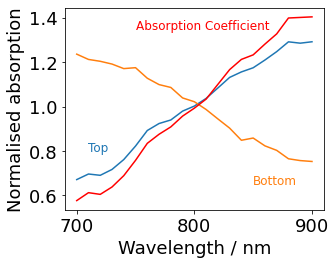

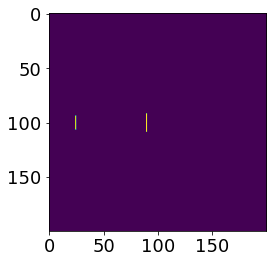

In [68]:
z_slices = [24, 89]
loc_labels = ["Top of vessel"] + ["Bottom of vessel"] * (len(z_slices)-1)
for z, l in zip(z_slices, loc_labels):
    test = (volume_numbered[0] == 4) * 1
    test[:, z] *= 2
    spectrum = np.mean(ms_results[0][test==2], axis=0)
    spectrum /= np.mean(spectrum)
    plt.plot(wavelengths*1e9, spectrum, label=l)
expected = blood_mu_a(wavelengths, 0.9)
plt.plot(wavelengths*1e9, expected/np.mean(expected), c="red", label="'Ground Truth'")
plt.xlabel("Wavelength / nm")
plt.ylabel("Normalised absorption")
plt.text(710,0.8, "Top", c="C0", fontsize=12)
plt.text(850,0.65, "Bottom", c="C1", fontsize=12)
plt.text(750,1.35, "Absorption Coefficient", c="red",fontsize=12)
plt.tight_layout()
plt.savefig("../FiguresOutput/depth_top_bottom_spec.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

# Check that we are selecting the correct ROI
test = (volume_numbered[0] == 4) * 1
for z in z_slices:
    test[:, z] *= 2
plt.imshow(test==2)
plt.show()

